# Analysis of cancer cells from experiments 1 and 2 

This notebook provides example scripts for accessing and analyzing cancer cell data from both experiments. 

# Preparation
This list includes the necessary packages to run the notebook, along with some that may not be required here but are commonly used for exploring adata.

In [4]:
import os
import re
import time
import glob
import csv
import seqc
import h5py
import tables
import seqc.filter
import warnings
import itertools
import harmony
import palantir as pl
import scvelo as scv
import cellrank as cr
import collections
import statsmodels
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import doubletdetection
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
import scanpy as sc
import seaborn as sns
import scrublet as scr
import anndata as ad
import networkx as nx
import logging
import scipy.cluster.hierarchy as shc
import scanpy.external as sce
import logging

from pathlib import Path
from typing import Dict
from scipy import sparse
from scipy import io
from scipy.sparse.csgraph import connected_components
from sklearn.preprocessing import normalize
from itertools import compress
from kneed import KneeLocator
from copy import deepcopy
from seqc import plot
from seqc.plot import FigureGrid
from collections import OrderedDict
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from seqc.sparse_frame import SparseFrame
from scipy.io import mmwrite
from adjustText import adjust_text

In [5]:
# Define and customize plot attributes
%matplotlib inline
sc.set_figure_params(dpi=80) 

sns.set_style("whitegrid")
mpl.rcParams['figure.figsize'] = [4,4]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['image.cmap'] = 'Spectral_r'
mpl.style.use("ggplot")
mpl.rcdefaults()
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

logging.getLogger('matplotlib').setLevel(logging.ERROR)

# Initialize

adata is the scran output of log-transformed, normalized UMI counts.

In [6]:
# Change directory to the desired path:
DATA_DIR = '/data/massague/gans/projects/Breast_tumor/GitHub/Data/'

# Sub-directory for the cancer cell data from experiments 1 and 2
source = 'Cancer_1_2/'

# Processed adata
for h5_file in Path(DATA_DIR+source).glob('*.h5'):    
    adata = sc.read(h5_file) # Log-transformed, normalized data

# Core processing steps

This section provides example code for the core, universal functions used throughout the study.
## Principal component analysis (PCA)

In [18]:
def PCA(a, n_HVG=5000, n_pcs=500):
    """" Function to run PCA using all robustly detected relevant genes or top HVGs
    a: adata matrix 
    param n_HVG: No. of HVGs to use (0 means uses all robustly detected relevant genes)
    param n_pcs: No. of PCs to calculate
    """
    
    temp = a[:,a.var['relevant']]
    if n_HVG>0:
        sc.pp.highly_variable_genes(temp, n_top_genes=n_HVG, flavor='cell_ranger')
        temp = temp[:,temp.var['highly_variable']]
        
    sc.tl.pca(temp, n_comps=n_pcs, svd_solver='arpack')

    a.uns['pca'] = temp.uns['pca'].copy()
    a.obsm['X_pca'] = temp.obsm['X_pca'].copy()
    a.uns['pca']['No_HVG'] = n_HVG
    del temp

In [22]:
def PlotPCA(a, fixed_n_pcs=0, fixed_total_var=0, file_name=''):
    """" Function to highlight populations in the same figure 
    : param a: adata matrix
    : param n_pcs: the No. of total PCs to compute
    : param fixed_n_pcs: use a fixed No. of PCs (rather than knee point-determined)
    : param file_name: used for indicating the data nature (e.g. imputed data)
    """
    
    n_pcs = a.obsm['X_pca'].shape[1]
    i_pcs = np.arange(n_pcs)
    lib_cor = np.zeros(n_pcs) 
    cum_var = np.zeros(n_pcs) 

    for i in range(n_pcs):
        lib_cor[i] = sp.stats.pearsonr(a.obsm['X_pca'][:,i], 
                                       a.obs['total_counts'])[0]
        cum_var[i] = np.sum(a.uns['pca']['variance_ratio'][0:i+1])

    a.uns['pca']['cor_library_size'] = lib_cor    
    a.uns['pca']['cum_variance_ratio'] = cum_var

    if fixed_n_pcs>0:
        # Fix to 300 PCs
        a.uns['pca']['no_pcs'] = fixed_n_pcs
    elif fixed_total_var>0:
        a.uns['pca']['no_pcs'] = np.where(a.uns['pca']['cum_variance_ratio']>=fixed_total_var)[0][0]
    else:
        # Use the knee point to determine how many PCs to use 
        kneedle = KneeLocator(i_pcs, a.uns['pca']['cum_variance_ratio'], S=1, 
                  curve='concave', direction='increasing')
        a.uns['pca']['no_pcs'] = round(kneedle.knee, 3)    

    # Plotting    
    sc.pl.pca_variance_ratio(a, n_pcs=n_pcs, log=False, show=True)

    data = pd.DataFrame({'ranking':i_pcs, 'Cumulative variance ratio':a.uns['pca']['cum_variance_ratio']})
    sns.lineplot(x="ranking", y="Cumulative variance ratio", data=data)
    plt.plot([a.uns['pca']['no_pcs'], a.uns['pca']['no_pcs']], [0, 1], color='r')
    
    plt.figure()
    data = pd.DataFrame({'ranking':i_pcs, 'Correlation with library size':a.uns['pca']['cor_library_size']})
    sns.lineplot(x="ranking", y="Correlation with library size", data=data)

    sc.pl.pca(a, color='total_counts',cmap='jet')
    print(a.uns['pca']['no_pcs'], cum_var[a.uns['pca']['no_pcs']])

In [19]:
PCA(adata, n_HVG=5000, n_pcs=500)

Trying to set attribute `.uns` of view, copying.


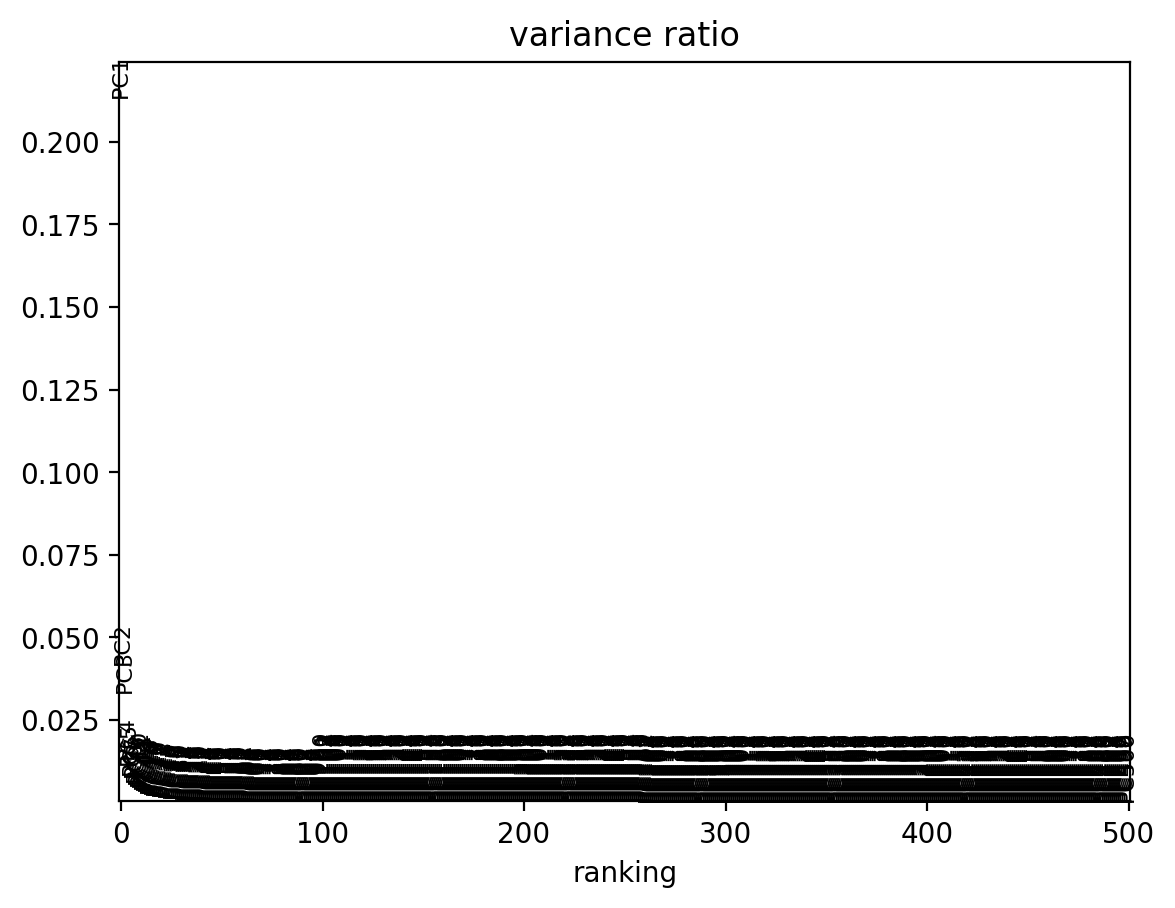

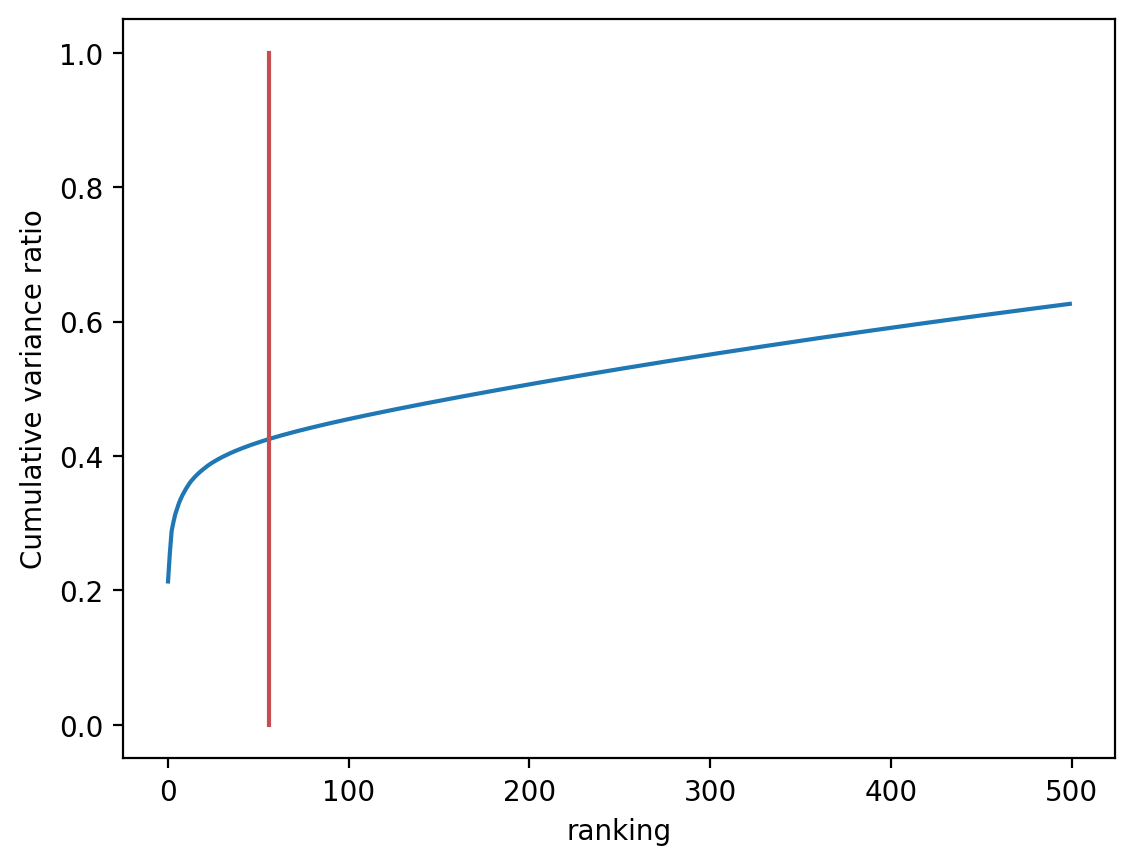

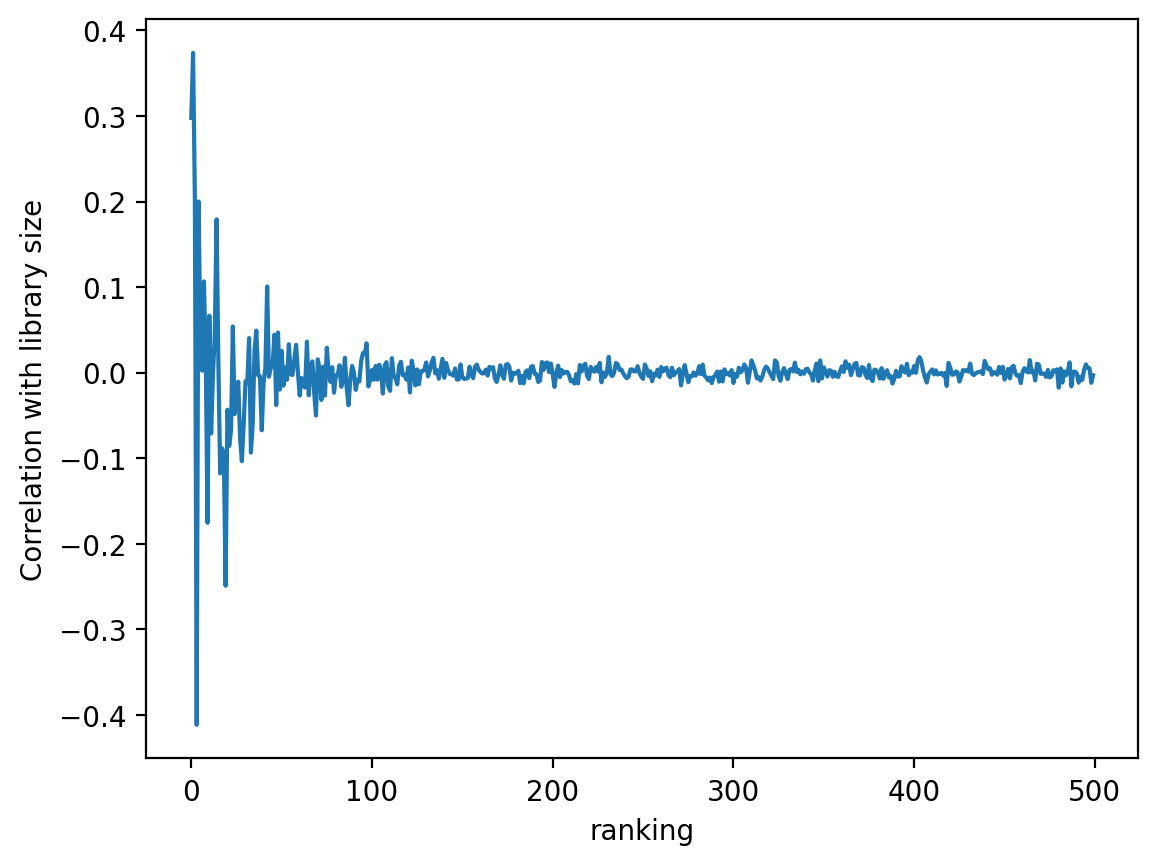

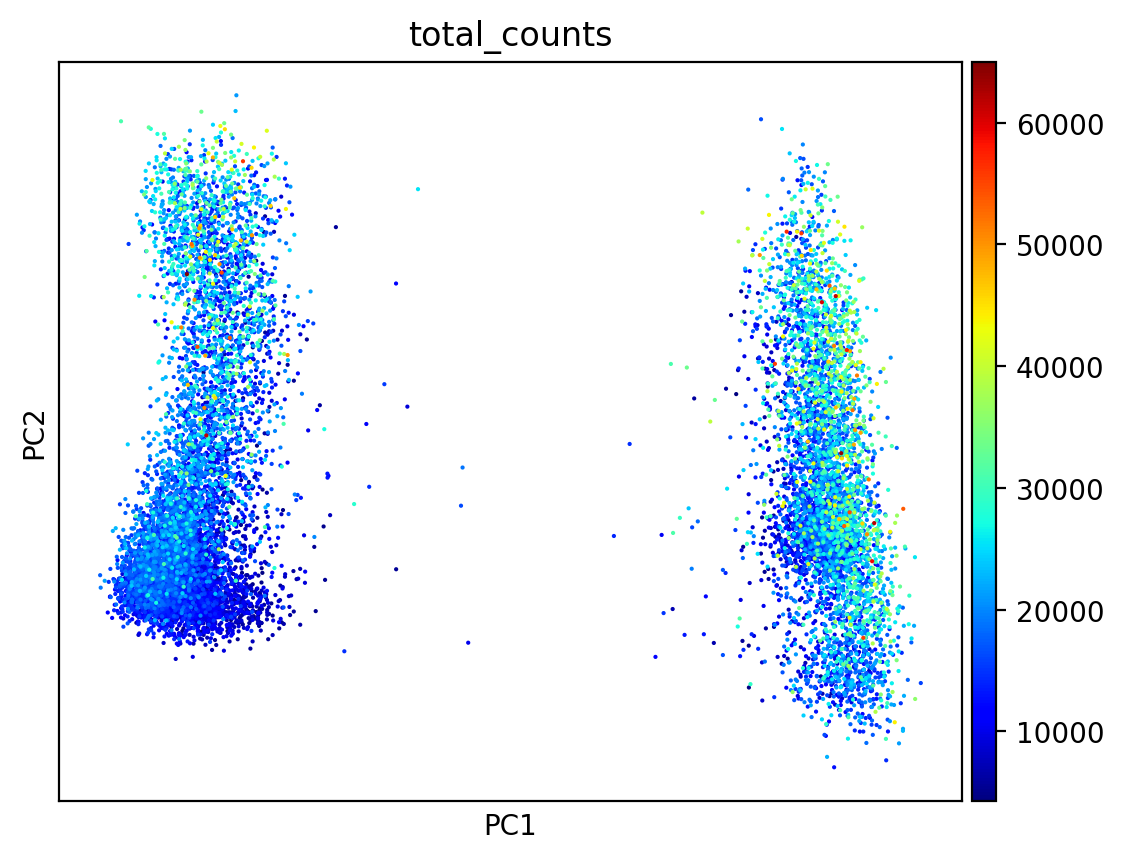

56 0.4254394769668579


In [23]:
PlotPCA(adata)

## Phenograph clustering

In [24]:
result = sce.tl.phenograph(adata.obsm['X_pca'][:,0:adata.uns['pca']['no_pcs']], k=30) # No. of neighbors: 30
adata.obs['pheno'] = pd.Categorical(result[0])

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 4.549615859985352 seconds
Jaccard graph constructed in 3.584642171859741 seconds
Wrote graph to binary file in 0.18324828147888184 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.81575
After 5 runs, maximum modularity is Q = 0.817062
After 12 runs, maximum modularity is Q = 0.818938
After 31 runs, maximum modularity is Q = 0.819992
Louvain completed 51 runs in 11.816220045089722 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 22.547616481781006 seconds


## UMAP embedding

In [25]:
sc.pp.neighbors(adata, n_neighbors=15, 
                n_pcs=adata.uns['pca']['no_pcs'], method='umap')         
sc.tl.umap(adata)

# Analysis & Visualization

## Examine validated sample information and expression of interested genes

Since many visualization and analysis steps rely on a random number seed, each run may produce slight variations. For consistency in this illustration, we load and use the data as processed in the manuscript.


<b> Batch (experiment 1 vs. 2) and tumor subtype </b>

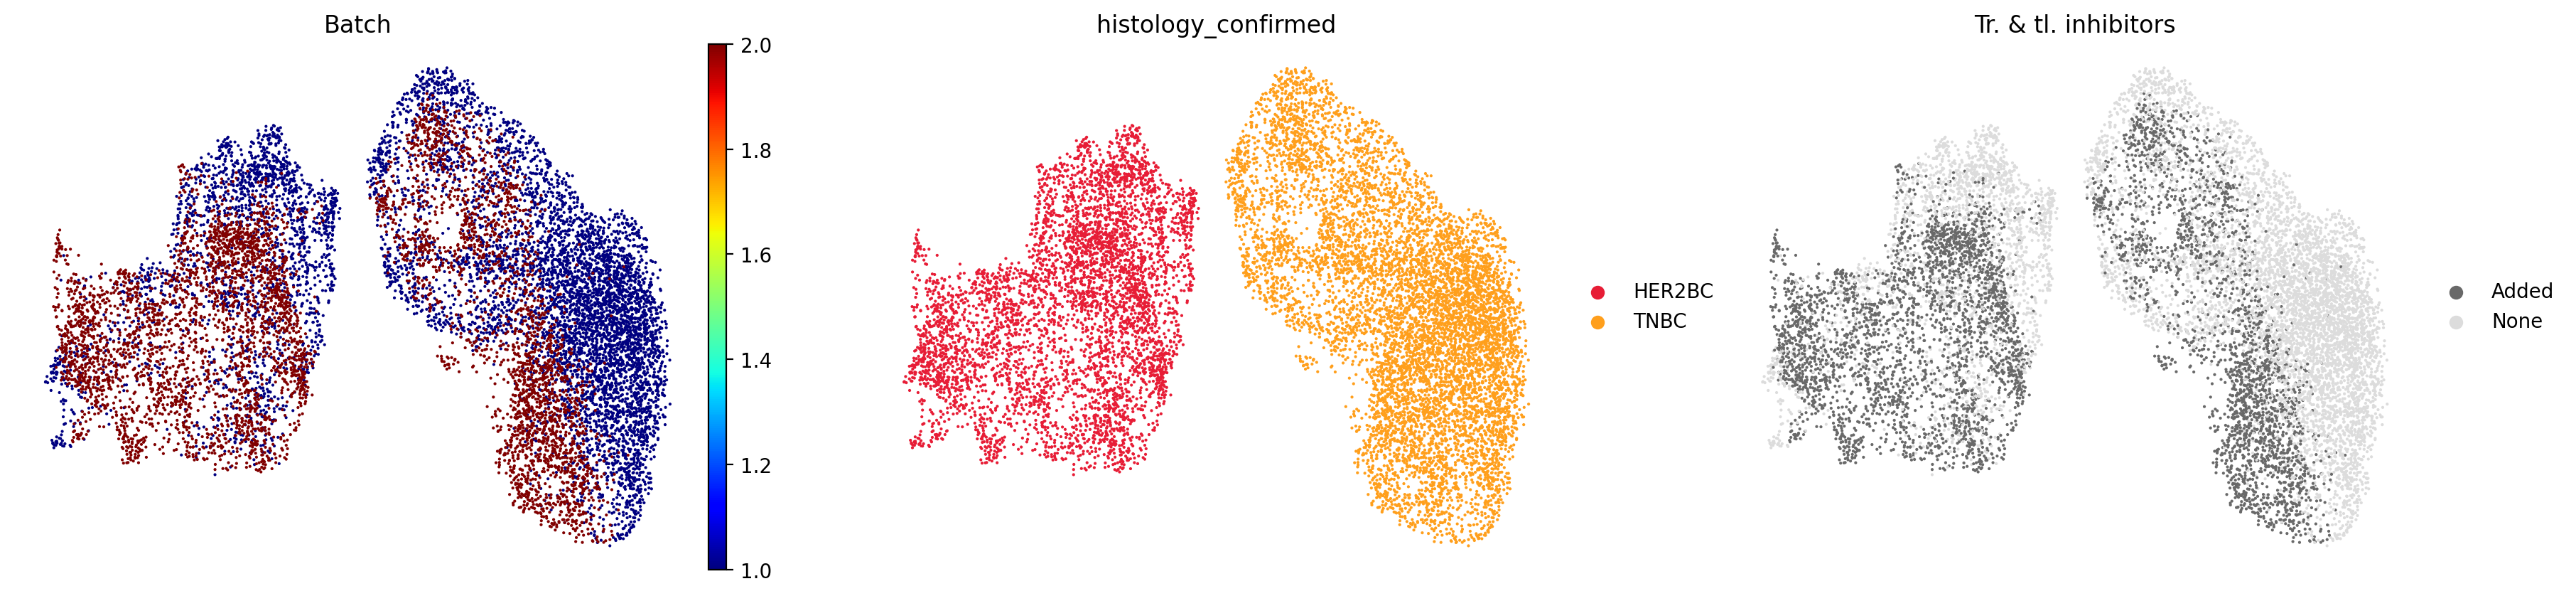

In [12]:
# Randomize the order of data points to plot
vis_rand = np.random.choice(range(adata.shape[0]),
                            replace=False, size=adata.shape[0])

sc.pl.umap(adata[vis_rand], 
           color=['Batch', # Experiment 1 vs. 2
                  'histology_confirmed', 
                  # Triple-negative (TNBC) vs. HER2+ breast cancer (HER2BC)
                  'Tr. & tl. inhibitors'
                  # Whether transcription and translation inhibitors are added (Experiment 2) or not (Experiment 1) 
                 ], 
           cmap='jet',
           frameon = False) 

<b> Tumor subtype in Experiment 1 vs. 2 </b>

Cells from the other experiment are shown in gray.

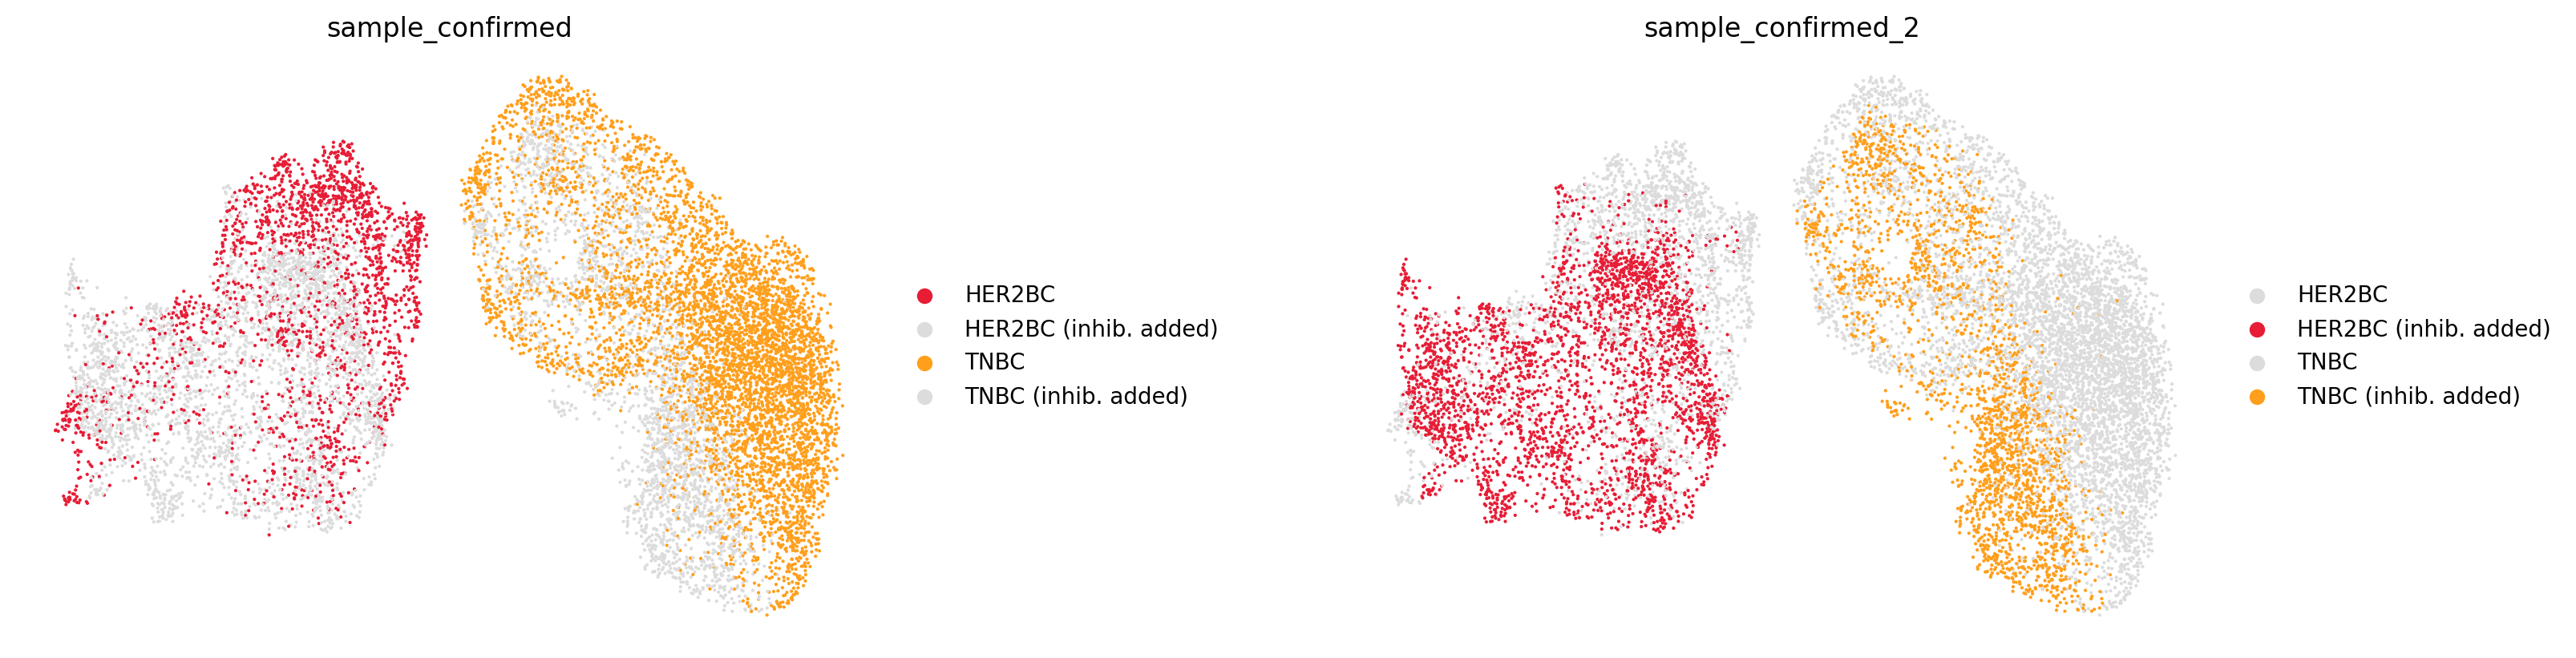

In [15]:
sc.pl.umap(adata[vis_rand], 
           color=['sample_confirmed',
                  'sample_confirmed_2',
                 ], 
           wspace=0.4, 
           cmap='jet',
           frameon = False) 

<b> Gene expression on UMAP embedding </b>

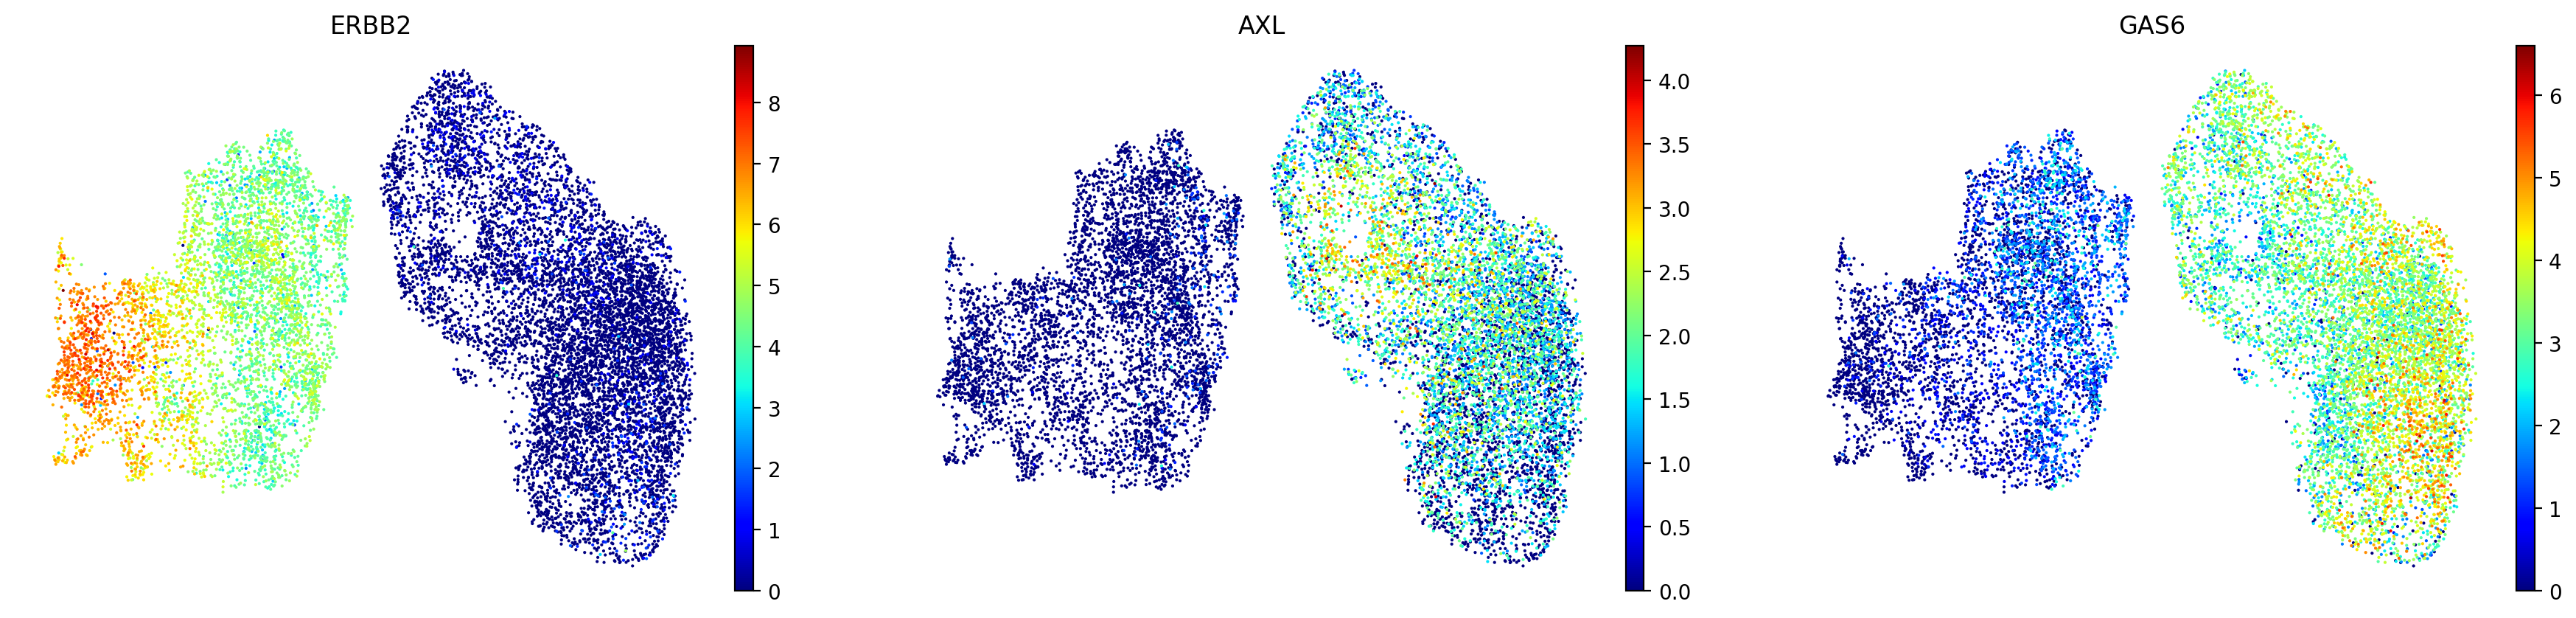

In [17]:
sc.pl.umap(adata[vis_rand], 
           color=['ERBB2','AXL','GAS6'], 
           cmap='jet',
           frameon = False) 

<b> Gene expressiona shown by violin plot </b>

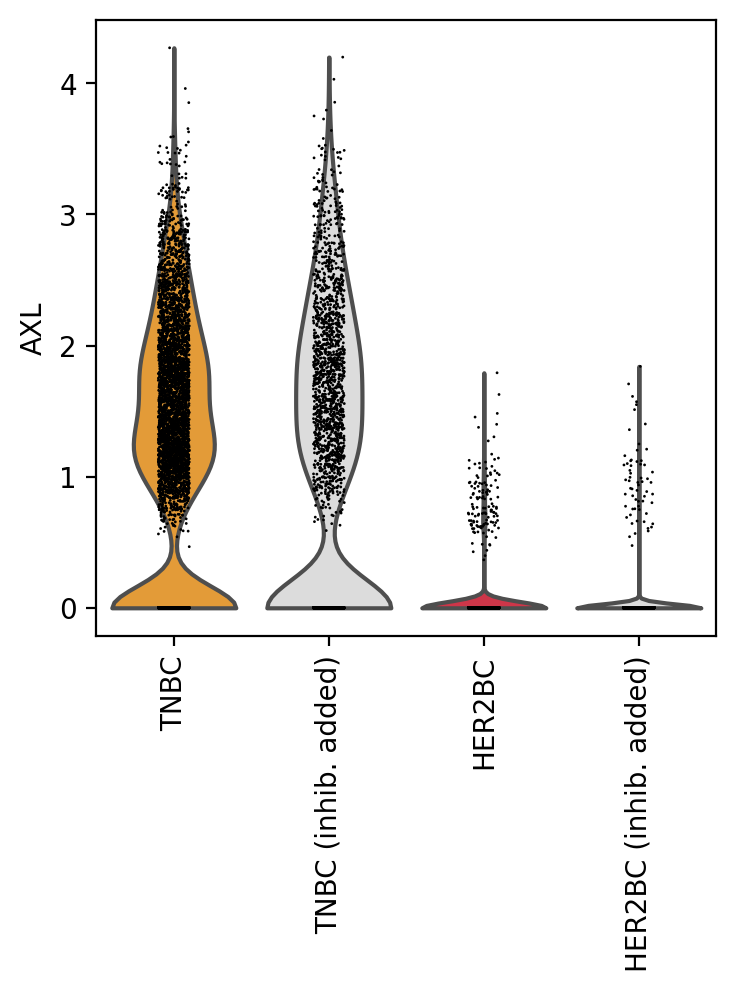

In [37]:
fig, ax = plt.subplots(figsize=[4,4])
ax.grid(False)

sc.pl.violin(adata, ['AXL'], 
             groupby='sample_confirmed',
             swap_axes=True,
             order=['TNBC','TNBC (inhib. added)',
                    'HER2BC','HER2BC (inhib. added)'],
             ax=ax, rotation=90) 

# Save results

In [34]:
# Save udpated adata to the original directory
for h5_file in Path(DATA_DIR+source).glob('*.h5'):   
    adata.write(h5_file)